# Tarea Semana 10

Su jefe le solicita ajustar un modelo que sea capaz de monitorizar las preguntas en stackoverflow de la siguiente manera:

1. Si seconsidera una buena pregunta debe mostrarla en la página de inicio y felicitar al usuario.
2. Si la pregunta es no cumple con las reglas del sitio o los lineamientos debe eliminarse automáticamente.
3. En cualquier otro caso, debe recomendarle al usuario revisar la pregunta.

Utilice el dataset de kaggle: [60k Stack Overflow Questions with Quality Rating](https://www.kaggle.com/imoore/60k-stack-overflow-questions-with-quality-rate) para ajustar un modelo que sea capaz de clasificar las preguntas en una de las siguientes categorias:

1. `HQ`: High-quality posts with a total of 30+ score and without a single edit.
2. `LQ_EDIT`: Low-quality posts with a negative score, and multiple community edits. However, they still remain open after those changes.
3. `LQ_CLOSE`: Low-quality posts that were closed by the community without a single edit.


Evaluación:
1. Análisis de datos (3 pts)
2. Limpieza y preparación del dataset (5 pts)
3. Ajuste al menos 2 modelos diferentes (2 pts)
4. [Opcional] Utilice GridSearchCV o RandomizedSearchCV
5. Evalúe cada modelo utilizando el accuracy y una matriz de confusión. (4 pts)
6. Mencione que caracteristicas posee una pregunta para ser clasificada como HQ, LQ_EDIT o LQ_CLOSE. (6 pts)
7. Implemente una función llamada `CheckQuestion` que reciba como parámetro un texto (la pregunta) y retorne la predicción. (10 pts)

In [6]:
import pandas as pd 
import numpy as np
import re
import nltk

# Data

In [7]:
StackOverflow = pd.read_csv("data/soq.csv", index_col=0)
StackOverflow.head()

,Title,Body,Tags,CreationDate,Y
Id,,,,,
34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


# Data Cleansing

In [8]:
df=StackOverflow[['Tags']]

Convert the tags in different technologies by removing the open bracket '<' and adding a comma,the use split to separate by values

In [10]:
df

,Tags
Id,
34552656,<java><repeat>
34553034,<java><optional>
34553174,<javascript><image><overlay><react-native><opa...
34553318,<swift><operators><whitespace><ternary-operato...
34553755,<android><material-design><floating-action-but...
...,...
60461435,<c#><asp.net><sql-server>
60461754,<python>
60462001,<azure><billing>


In [11]:
def separatetags(tag):
    str1=re.sub(r'>', '/', tag)
    str2=re.sub(r'<', '', str1)
    return str2[:-1]
    

In [12]:
df["_Tags"]=df.apply(lambda row: separatetags(row['Tags']), axis=1)

<ipython-input-12-63a5a601f928>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["_Tags"]=df.apply(lambda row: separatetags(row['Tags']), axis=1)


In [13]:
df=df.drop(['Tags'],axis=1)
#prep_df=df.drop(['Loan_ID','terms'],axis=1).copy()

In [14]:
s=df.stack()

In [15]:
df_tech=pd.DataFrame(s.str.rsplit("/", expand=True))


In [16]:
df_tech

,,0,1,2,3,4,5
Id,,,,,,,
34552656,_Tags,java,repeat,None,None,None,None
34553034,_Tags,java,optional,None,None,None,None
34553174,_Tags,javascript,image,overlay,react-native,opacity,None
34553318,_Tags,swift,operators,whitespace,ternary-operator,optional,None
34553755,_Tags,android,material-design,floating-action-button,None,None,None
...,...,...,...,...,...,...,...
60461435,_Tags,c#,asp.net,sql-server,None,None,None
60461754,_Tags,python,None,None,None,None,None
60462001,_Tags,azure,billing,None,None,None,None


In [17]:
df_tech=df_tech.set_axis(["Tech0", "Tech1", "Tech2", "Tech3", "Tech4", "Tech5"], axis=1)

In [18]:
df_inner = pd.merge( StackOverflow,df_tech, on='Id', how='inner')

In [19]:
def convert(value):
    string= "null" if value is None else value
    return string

In [20]:
df_inner["Tech0"]=df_inner.apply(lambda row: convert(row['Tech0']), axis=1)
df_inner["Tech1"]=df_inner.apply(lambda row: convert(row['Tech1']), axis=1)
df_inner["Tech2"]=df_inner.apply(lambda row: convert(row['Tech2']), axis=1)
df_inner["Tech3"]=df_inner.apply(lambda row: convert(row['Tech3']), axis=1)
df_inner["Tech4"]=df_inner.apply(lambda row: convert(row['Tech4']), axis=1)
df_inner["Tech5"]=df_inner.apply(lambda row: convert(row['Tech5']), axis=1)

In [21]:
df_inner

,Title,Body,Tags,CreationDate,Y,Tech0,Tech1,Tech2,Tech3,Tech4,Tech5
Id,,,,,,,,,,,
34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,java,repeat,null,null,null,null
34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,java,optional,null,null,null,null
34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,javascript,image,overlay,react-native,opacity,null
34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,swift,operators,whitespace,ternary-operator,optional,null
34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,android,material-design,floating-action-button,null,null,null
...,...,...,...,...,...,...,...,...,...,...,...
60461435,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,<c#><asp.net><sql-server>,2020-02-29 02:22:18,LQ_CLOSE,c#,asp.net,sql-server,null,null,null
60461754,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,<python>,2020-02-29 03:33:59,LQ_CLOSE,python,null,null,null,null,null
60462001,how to change payment date in Azure?,<p>It looks like it costs 8 days per month in ...,<azure><billing>,2020-02-29 04:34:16,LQ_CLOSE,azure,billing,null,null,null,null


Merge the datasets

In [22]:
questions=df_inner.drop(['Tags','CreationDate'],axis=1)

In [23]:
questions.groupby(by=['Tech0']).count()

,Title,Body,Y,Tech1,Tech2,Tech3,Tech4,Tech5
Tech0,,,,,,,,
.htaccess,5,5,5,5,5,5,5,5
.net,95,95,95,95,95,95,95,95
.net-core,15,15,15,15,15,15,15,15
2d,1,1,1,1,1,1,1,1
3d,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...
z3,1,1,1,1,1,1,1,1
zabbix,1,1,1,1,1,1,1,1
zip,1,1,1,1,1,1,1,1


# Model #1

Using the Title

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

# tokenizer para eliminar elementos no deseados de los datos como símbolos y números
token = RegexpTokenizer(r'[a-zA-Z]+')

cv = CountVectorizer(
    lowercase=True, 
    stop_words='english', 
    ngram_range = (1,3), 
    tokenizer = token.tokenize,
    max_features=2000
)

text_counts = cv.fit_transform(questions['Title'])

In [25]:
print(cv.get_feature_names())

['able', 'absolute', 'abstract', 'accept', 'access', 'accessing', 'according', 'account', 'achieve', 'action', 'actions', 'active', 'activity', 'actual', 'actually', 'adapter', 'add', 'add new', 'added', 'adding', 'address', 'addresses', 'admin', 'airflow', 'ajax', 'alert', 'algorithm', 'alias', 'align', 'allow', 'allowed', 'alternative', 'amazon', 'anaconda', 'analytics', 'andriod', 'android', 'android app', 'android application', 'android sdk', 'android studio', 'android support', 'angular', 'angular cli', 'angular js', 'angular material', 'angularjs', 'animate', 'animation', 'annotation', 'anonymous', 'ansible', 'answer', 'apache', 'api', 'api gateway', 'apk', 'apollo', 'app', 'appear', 'appears', 'append', 'apple', 'application', 'applications', 'applied', 'apply', 'approach', 'apps', 'architecture', 'arduino', 'area', 'args', 'argument', 'arguments', 'array', 'array array', 'array c', 'array java', 'array javascript', 'array list', 'array object', 'array objects', 'array php', 'ar

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text_counts, questions['Y'], test_size=0.3, random_state=1)

In [27]:
from sklearn.naive_bayes import MultinomialNB

# bayes ingenuo multinomiales
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)

In [28]:
from sklearn import metrics
from sklearn.metrics import classification_report

target_names = ['HQ', 'LQ_EDIT','LQ_CLOSE']
print(classification_report(y_test, predicted, target_names=target_names))

              precision    recall  f1-score   support

          HQ       0.72      0.76      0.74      4531
     LQ_EDIT       0.52      0.56      0.54      4421
    LQ_CLOSE       0.57      0.49      0.52      4548

    accuracy                           0.60     13500
   macro avg       0.60      0.60      0.60     13500
weighted avg       0.60      0.60      0.60     13500



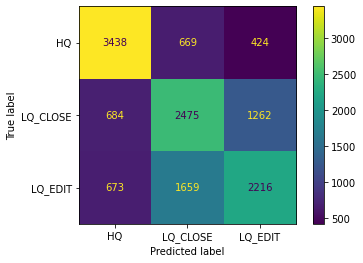

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

# cantidad de decimales
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(
    clf, 
    X_test, 
    y_test, 
    display_labels=clf.classes_, 
    normalize=None
)

plt.show()

Using the Body

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

# tokenizer para eliminar elementos no deseados de los datos como símbolos y números
token = RegexpTokenizer(r'[a-zA-Z]+')

cv = CountVectorizer(
    lowercase=True, 
    stop_words='english', 
    ngram_range = (1,3), 
    tokenizer = token.tokenize,
    max_features=2000
)

text_counts = cv.fit_transform(questions['Body'])

In [31]:
print(cv.get_feature_names())

['abc', 'able', 'accept', 'access', 'according', 'account', 'achieve', 'action', 'active', 'activity', 'activitythread', 'activitythread java', 'activitythread java android', 'actual', 'actually', 'ad', 'adams', 'adams county', 'adams county adams', 'adapter', 'add', 'add new', 'added', 'adding', 'address', 'admin', 'advance', 'advance p', 'age', 'ajax', 'alert', 'algorithm', 'align', 'align center', 'allow', 'allowed', 'alpha', 'alt', 'alt enter', 'alt enter image', 'amp', 'amp amp', 'android', 'android android', 'android app', 'android app activitythread', 'android com', 'android id', 'android id id', 'android internal', 'android layout', 'android layout height', 'android layout width', 'android os', 'android studio', 'android support', 'android support v', 'android view', 'android widget', 'angular', 'animation', 'answer', 'answers', 'anybody', 'apache', 'api', 'apk', 'app', 'app activitythread', 'app layout', 'appcompatactivity', 'appear', 'appears', 'append', 'apple', 'application

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text_counts, questions['Y'], test_size=0.3, random_state=1)

In [36]:
from sklearn.naive_bayes import MultinomialNB

# bayes ingenuo multinomiales
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)

In [37]:
from sklearn import metrics
from sklearn.metrics import classification_report

target_names = ['HQ', 'LQ_EDIT','LQ_CLOSE']
print(classification_report(y_test, predicted, target_names=target_names))

              precision    recall  f1-score   support

          HQ       0.74      0.84      0.78      4531
     LQ_EDIT       0.81      0.70      0.75      4421
    LQ_CLOSE       0.96      0.95      0.95      4548

    accuracy                           0.83     13500
   macro avg       0.83      0.83      0.83     13500
weighted avg       0.84      0.83      0.83     13500



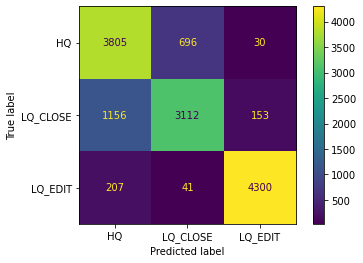

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

# cantidad de decimales
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(
    clf, 
    X_test, 
    y_test, 
    display_labels=clf.classes_, 
    normalize=None
)

plt.show()

Es mas acertado la iteracion #2 utilizando el body

# Model #2

In [39]:
techs = np.array((questions['Tech0'],questions['Tech1'],questions['Tech2'],questions['Tech3'],questions['Tech4'],questions['Tech5']))

In [40]:
techs

array([['java', 'java', 'javascript', ..., 'azure', 'ios', 'c#'],
       ['repeat', 'optional', 'image', ..., 'billing', 'swift',
        'visual-studio'],
       ['null', 'null', 'overlay', ..., 'null', 'null', 'null'],
       ['null', 'null', 'react-native', ..., 'null', 'null', 'null'],
       ['null', 'null', 'opacity', ..., 'null', 'null', 'null'],
       ['null', 'null', 'null', ..., 'null', 'null', 'null']],
      dtype=object)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(questions['Tech0'])
print(vectorizer.get_feature_names())

['04', '10', '11', '14', '16', '18', '2008', '2010', '2012', '2013', '2015', '2016', '2017', '2019', '2d', '3d', 'abap', 'access', 'accessibility', 'account', 'actions', 'actionscript', 'active', 'activestorage', 'activiti', 'adblock', 'addins', 'adf', 'admin', 'adminer', 'admob', 'ads', 'aem', 'aframe', 'ag', 'aggregate', 'agile', 'airflow', 'ajax', 'akka', 'alchemyapi', 'alembic', 'alertdialog', 'alfresco', 'algebra', 'algorithm', 'alignment', 'amazon', 'amp', 'anaconda', 'analysis', 'analytics', 'android', 'angular', 'angular2', 'angular5', 'angular6', 'angular7', 'angularjs', 'animation', 'annotations', 'ansible', 'antd', 'antivirus', 'antlr', 'apache', 'api', 'api2', 'apollo', 'app', 'appcelerator', 'application', 'applications', 'apps', 'arcgis', 'architect', 'architecture', 'arduino', 'arm', 'arrays', 'artificial', 'asciidoc', 'asp', 'aspnetboilerplate', 'assembly', 'asterisk', 'async', 'asynchronous', 'asynctask', 'athena', 'atlassian', 'atom', 'attributes', 'audio', 'aurelia',

In [43]:
vectorizer.vocabulary_

{'java': 582,
 'javascript': 584,
 'swift': 1124,
 'android': 52,
 'jquery': 597,
 'vb6': 1224,
 'linux': 656,
 'ios': 561,
 'haskell': 494,
 'arrays': 79,
 'amazon': 47,
 'web': 1251,
 'services': 1040,
 'bluebird': 134,
 'powershell': 893,
 'vbscript': 1226,
 'scala': 1008,
 'kotlin': 628,
 'nginx': 769,
 'elixir': 359,
 'mysql': 748,
 'mongodb': 733,
 'studio': 1109,
 'python': 926,
 'php': 861,
 'matlab': 696,
 'playframework': 872,
 'jekyll': 587,
 'node': 778,
 'js': 598,
 'html': 509,
 'codenameone': 211,
 'angularjs': 58,
 'hadoop': 485,
 'asp': 82,
 'net': 760,
 'image': 528,
 'typescript': 1189,
 'django': 324,
 'code': 207,
 'generation': 451,
 'css': 273,
 'facebook': 395,
 'debugging': 300,
 'ffmpeg': 402,
 'postgresql': 888,
 'angular': 53,
 'sublimetext2': 1112,
 'spring': 1084,
 'ssl': 1092,
 'titan': 1169,
 'docker': 327,
 'date': 294,
 'wordpress': 1275,
 'git': 456,
 'ssh': 1090,
 'delphi': 302,
 'google': 467,
 'cloud': 196,
 'platform': 869,
 'ruby': 991,
 'apache'

In [57]:
df = pd.DataFrame(
    X.todense(),
    columns=vectorizer.get_feature_names()
)
df=df.sort_values(by=0, axis=1, ascending=False, inplace=False, kind='quicksort', na_position='last')
df

,java,04,playbook,plus,plunker,plugins,plugin,plsql,plot,plc,...,functions,fortran,functional,function,full,frontend,frameworks,framework,fragments,zsh
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorge.munoz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jorge.munoz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
print(stopwords.words('english'))

## Videos de la Semana

[This Magical AI Cuts People Out Of Your Videos!](https://www.youtube.com/watch?v=lCBSGOwV-_o)

[AI Generates Cartoon Characters In Real Life](https://www.youtube.com/watch?v=g-N8lfceclI)

[INTRO al Natural Language Processing (NLP) #1 - ¡De PALABRAS a VECTORES!](https://www.youtube.com/watch?v=Tg1MjMIVArc)

[INTRO al Natural Language Processing (NLP) #2 - ¿Qué es un EMBEDDING?](https://www.youtube.com/watch?v=RkYuH_K7Fx4)


## Lecturas Recomendada

[An In-Depth Guide to How Recommender Systems Work](https://builtin.com/data-science/recommender-systems)

[How to build robust anomaly detectors with machine learning](https://www.ericsson.com/en/blog/2020/4/anomaly-detection-with-machine-learning)